In [44]:
# %%
import numpy as np
import pandas as pd
import sys
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [45]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [46]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.tree_evaluator import TreeEvaluator

In [47]:
# Импортируем все функции из папки pairs_3 поименно
from src.pairs_3.complete_meeting_analysis import complete_meeting_analysis
from src.pairs_3.create_chronological_meetings import create_chronological_meetings
from src.pairs_3.optimize_grandchild_parent_distance import optimize_grandchild_parent_distance
from src.pairs_3.optimize_grandchild_pair_distance import optimize_grandchild_pair_distance

from src.pairs_3.extract_pairs_from_chronology import (
    extract_pairs_from_chronology,
    get_pair_details,
    analyze_pair_statistics,
    export_pairs_to_csv
)
from src.pairs_3.create_meeting_chronology import (
    create_meeting_chronology,
    export_chronology_to_csv,
    get_meeting_recommendations
)
from src.pairs_3.build_distance_tables import (
    build_grandchild_distance_tables,
    build_grandchild_parent_distance_tables
)
from src.pairs_3.compute_convergence_tables import (
    compute_distance_derivative_table,
    compute_grandchild_parent_convergence_table
)
from src.pairs_3.find_converging_pairs import (
    find_converging_grandchild_pairs,
    find_converging_grandchild_parent_pairs
)
from src.pairs_3.extract_optimal_dt_from_pairs import (
    extract_optimal_dt_from_pairs,
    create_optimized_tree_from_pairs,
    compare_trees_distances
)

In [48]:
def draw_rk(pendulum, state, control, N = 50, total_dt=0.01, show=False):
    poses = [state]
    dt = total_dt/N
    for i in range(1, N+1):
        poses.append(pendulum.step(poses[-1], control, dt))

    return np.array(poses)

In [49]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

init_position = np.array([np.pi , -1])

cfg = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.1,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 10)
)
cfg.validate()

True

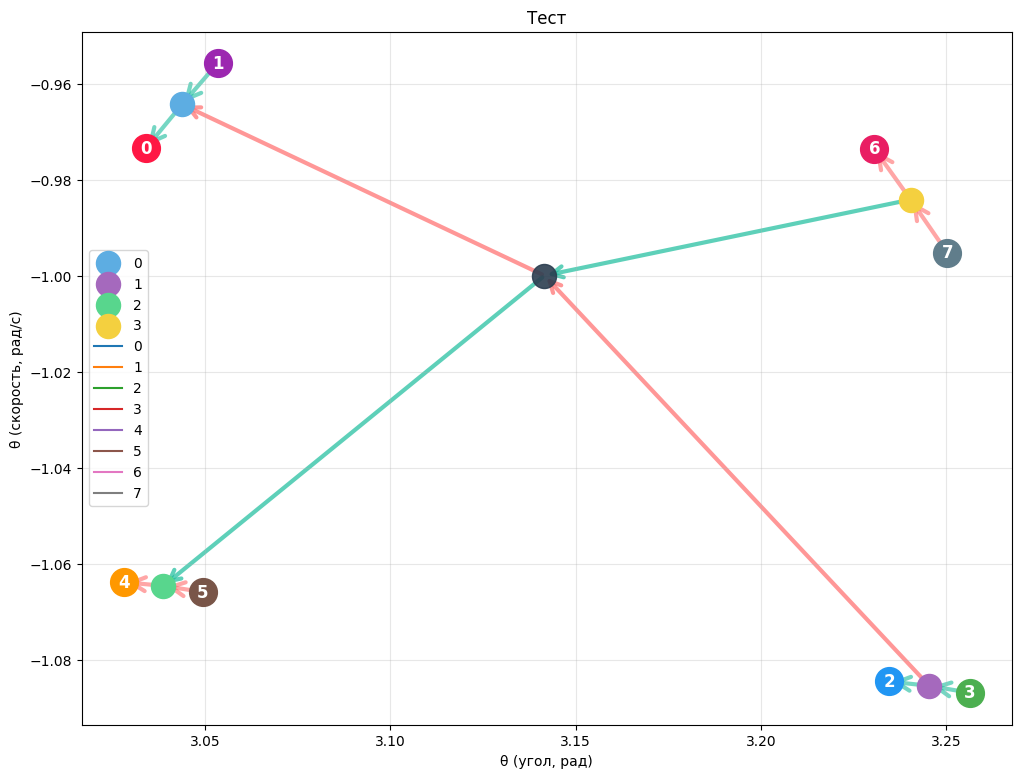

In [50]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")


poses = []
# dts = [0.01, 0.005, 0.003, 0.003, 0.01, 0.006, 0.003, 0.003]
dts = [1.5, -0.07897676, 0.07897674, -0.9, 0.00, 0.00, 0.00, 0.000] 
dts = np.array(dts) *0

for i in range(len(grandchildren)):
    parent_pos = children[grandchildren[i]['parent_idx']]['position']
    sign = grandchildren[i]['dt'] / grandchildren[i]['dt_abs']
    control = grandchildren[i]['control']
    poses_1 = draw_rk(pendulum, state=parent_pos, control=control, total_dt=dts[i])

    plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{i}')

plt.legend()


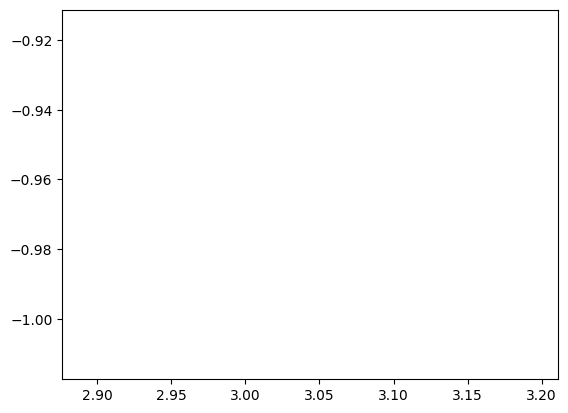

In [51]:
i = 1
parent_pos = children[grandchildren[i]['parent_idx']]['position']
sign = grandchildren[i]['dt'] / grandchildren[i]['dt_abs']
control = grandchildren[i]['control']
poses_1 = draw_rk(pendulum, state=parent_pos, control=control, total_dt=dts[i], show=True)

plt.plot(poses_1[:, 0], poses_1[:, 1])

In [52]:
tree.children[0]['dt']

0.1

In [53]:
# Ячейка 1: Проверяем базовую информацию о дереве
print("=== БАЗОВАЯ ИНФОРМАЦИЯ О ДЕРЕВЕ ===")
print(f"✅ Дети созданы: {tree._children_created}")
print(f"✅ Внуки созданы: {tree._grandchildren_created}")
print(f"📊 Количество детей: {len(tree.children)}")
print(f"👶 Количество внуков: {len(tree.grandchildren)}")

print(f"\n📍 Корневая позиция: {tree.root['position']}")

print(f"\n🍄 ДЕТИ:")
for i, child in enumerate(tree.children):
    direction = "forward" if child['dt'] > 0 else "backward"
    print(f"  {i}: {child['name']} - u={child['control']:+.1f}, dt={child['dt']:+.4f} ({direction})")
    print(f"      позиция: {child['position']}")

print(f"\n👶 ВНУКИ:")
for i, gc in enumerate(tree.grandchildren):
    direction = "forward" if gc['dt'] > 0 else "backward"
    print(f"  {i}: {gc['name']} - родитель_{gc['parent_idx']}, u={gc['control']:+.1f}, dt={gc['dt']:+.5f} ({direction})")
    print(f"      позиция: {gc['position']}")

# Подсчет направлений времени
forward_count = sum(1 for gc in tree.grandchildren if gc['dt'] > 0)
backward_count = len(tree.grandchildren) - forward_count
print(f"\n⏰ Направления времени внуков:")
print(f"  Forward: {forward_count}, Backward: {backward_count}")

# Сохраняем данные для следующих ячеек
basic_tree_info = {
    'n_children': len(tree.children),
    'n_grandchildren': len(tree.grandchildren),
    'forward_gc_count': forward_count,
    'backward_gc_count': backward_count
}

=== БАЗОВАЯ ИНФОРМАЦИЯ О ДЕРЕВЕ ===
✅ Дети созданы: True
✅ Внуки созданы: True
📊 Количество детей: 4
👶 Количество внуков: 8

📍 Корневая позиция: [ 3.14159265 -1.        ]

🍄 ДЕТИ:
  0: forw_max - u=+2.0, dt=+0.1000 (forward)
      позиция: [ 3.04377981 -0.96433522]
  1: back_max - u=+2.0, dt=-0.1000 (backward)
      позиция: [ 3.24543413 -1.08547853]
  2: forw_min - u=-2.0, dt=+0.1000 (forward)
      позиция: [ 3.03877602 -1.06464773]
  3: back_min - u=-2.0, dt=-0.1000 (backward)
      позиция: [ 3.24039701 -0.98415791]

👶 ВНУКИ:
  0: gc_0_0_forward - родитель_0, u=-2.0, dt=+0.01000 (forward)
      позиция: [ 3.03409156 -0.97339249]
  1: gc_0_1_backward - родитель_0, u=-2.0, dt=-0.01000 (backward)
      позиция: [ 3.0533798  -0.95573988]
  2: gc_1_0_forward - родитель_1, u=-2.0, dt=+0.01000 (forward)
      позиция: [ 3.23458431 -1.08457406]
  3: gc_1_1_backward - родитель_1, u=-2.0, dt=-0.01000 (backward)
      позиция: [ 3.25629565 -1.08691374]
  4: gc_2_0_forward - родитель_2, u=+2.0

In [54]:
# Ячейка 2: Вычисляем таблицы скоростей сближения
from src.pairs_3.compute_convergence_tables import compute_distance_derivative_table, compute_grandchild_parent_convergence_table

print("=== ТАБЛИЦЫ СКОРОСТЕЙ СБЛИЖЕНИЯ ===")

print("\n🔹 Скорости сближения ВНУК-ВНУК:")
convergence_gc_gc = compute_distance_derivative_table(tree.grandchildren, pendulum, show=True)

print("\n🔹 Скорости сближения ВНУК-РОДИТЕЛЬ:")
convergence_gc_parent = compute_grandchild_parent_convergence_table(tree.grandchildren, tree.children, pendulum, show=True)

# Анализируем результаты
import numpy as np

# Статистика по внук-внук
gc_gc_values = convergence_gc_gc.values
upper_triangle = np.triu(gc_gc_values, k=1)  # Только верхний треугольник
valid_values = upper_triangle[upper_triangle != 0]

gc_gc_converging = (valid_values < -1e-6).sum()
gc_gc_diverging = (valid_values > 1e-6).sum()
gc_gc_stationary = len(valid_values) - gc_gc_converging - gc_gc_diverging

print(f"\n📊 СТАТИСТИКА ВНУК-ВНУК:")
print(f"  Сближающихся пар: {gc_gc_converging}")
print(f"  Расходящихся пар: {gc_gc_diverging}")
print(f"  Стационарных пар: {gc_gc_stationary}")
print(f"  Всего уникальных пар: {len(valid_values)}")

# Статистика по внук-родитель
gc_parent_values = convergence_gc_parent.values[~np.isnan(convergence_gc_parent.values)]
gc_parent_converging = (gc_parent_values < -1e-6).sum()
gc_parent_diverging = (gc_parent_values > 1e-6).sum()
gc_parent_stationary = len(gc_parent_values) - gc_parent_converging - gc_parent_diverging

print(f"\n📊 СТАТИСТИКА ВНУК-РОДИТЕЛЬ:")
print(f"  Сближающихся пар: {gc_parent_converging}")
print(f"  Расходящихся пар: {gc_parent_diverging}")
print(f"  Стационарных пар: {gc_parent_stationary}")
print(f"  Всего связей: {len(gc_parent_values)}")

# Сохраняем для следующих ячеек
convergence_data = {
    'gc_gc_table': convergence_gc_gc,
    'gc_parent_table': convergence_gc_parent,
    'gc_gc_converging_count': gc_gc_converging,
    'gc_parent_converging_count': gc_parent_converging
}

=== ТАБЛИЦЫ СКОРОСТЕЙ СБЛИЖЕНИЯ ===

🔹 Скорости сближения ВНУК-ВНУК:
Отладочная информация первых 3 внуков:
  Внук 0: dt=+0.01000 (forward)
    raw_dynamics=[-0.97339249 -0.9289386 ], time_direction=+1
  Внук 1: dt=-0.01000 (backward)
    raw_dynamics=[-0.95573988 -0.83654911], time_direction=-1
  Внук 2: dt=+0.01000 (forward)
    raw_dynamics=[-1.08457406  0.06392436], time_direction=+1
Таблица первых производных расстояний d/dt|r_i - r_j|:
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

         gc_0     gc_1     gc_2     gc_3     gc_4     gc_5     gc_6     gc_7
gc_0  0.00000  2.61505 -0.57874  1.48949 -0.97194 -0.42994 -0.00206  1.97903
gc_1  2.61505  0.00000 -1.21516  0.65665  1.22407  0.98713 -1.93934  0.42570
gc_2 -0.57874 -1.21516  0.00000  2.18406 -0.02188 -2.16164  0.96489 -0.81736
gc_3  1.48949  0.65665  2.18406  0.00000  2.16213  0.02237  1.62917 -0.95353
gc_4 -0.97194  1.22407 -0.02188  2.16213  0.00000  2.13978

In [55]:
# Ячейка 3: Находим сближающиеся пары
from src.pairs_3.find_converging_pairs import find_converging_grandchild_pairs, find_converging_grandchild_parent_pairs

print("=== ПОИСК СБЛИЖАЮЩИХСЯ ПАР ===")

print("\n🔹 Сближающиеся пары ВНУК-ВНУК:")
converging_gc_pairs = find_converging_grandchild_pairs(convergence_data['gc_gc_table'], show=True)

print("\n🔹 Сближающиеся пары ВНУК-РОДИТЕЛЬ:")
converging_gc_parent_pairs = find_converging_grandchild_parent_pairs(convergence_data['gc_parent_table'], show=True)

# Детальный анализ найденных пар
print(f"\n📋 ДЕТАЛЬНЫЙ АНАЛИЗ ПАР ВНУК-ВНУК:")
for i, pair in enumerate(converging_gc_pairs):
    gc_i = tree.grandchildren[pair['gc_i']]
    gc_j = tree.grandchildren[pair['gc_j']]
    print(f"  {i+1}. {pair['pair_name']} (скорость: {pair['velocity']:.6f})")
    print(f"     gc_{pair['gc_i']}: родитель_{gc_i['parent_idx']}, dt={gc_i['dt']:+.5f}")
    print(f"     gc_{pair['gc_j']}: родитель_{gc_j['parent_idx']}, dt={gc_j['dt']:+.5f}")
    print(f"     Один родитель: {'ДА' if gc_i['parent_idx'] == gc_j['parent_idx'] else 'НЕТ'}")

print(f"\n📋 ДЕТАЛЬНЫЙ АНАЛИЗ ПАР ВНУК-РОДИТЕЛЬ:")
for i, pair in enumerate(converging_gc_parent_pairs):
    gc = tree.grandchildren[pair['gc_idx']]
    parent = tree.children[pair['parent_idx']]
    print(f"  {i+1}. {pair['pair_name']} (скорость: {pair['velocity']:.6f})")
    print(f"     gc_{pair['gc_idx']}: родитель_{gc['parent_idx']}, dt={gc['dt']:+.5f}")
    print(f"     target_parent_{pair['parent_idx']}: dt={parent['dt']:+.5f}")
    print(f"     К своему родителю: {'ДА' if gc['parent_idx'] == pair['parent_idx'] else 'НЕТ'}")

# Проверяем ожидания vs реальность
expected_gc_pairs = convergence_data['gc_gc_converging_count']
found_gc_pairs = len(converging_gc_pairs)
expected_gc_parent_pairs = convergence_data['gc_parent_converging_count']
found_gc_parent_pairs = len(converging_gc_parent_pairs)

print(f"\n✅ ПРОВЕРКА СООТВЕТСТВИЯ:")
print(f"  Внук-внук: ожидали {expected_gc_pairs}, нашли {found_gc_pairs} {'✅' if expected_gc_pairs == found_gc_pairs else '❌'}")
print(f"  Внук-родитель: ожидали {expected_gc_parent_pairs}, нашли {found_gc_parent_pairs} {'✅' if expected_gc_parent_pairs == found_gc_parent_pairs else '❌'}")

# Сохраняем для следующих ячеек
pairs_data = {
    'converging_gc_pairs': converging_gc_pairs,
    'converging_gc_parent_pairs': converging_gc_parent_pairs,
    'expected_vs_found': {
        'gc_expected': expected_gc_pairs,
        'gc_found': found_gc_pairs,
        'gc_parent_expected': expected_gc_parent_pairs,
        'gc_parent_found': found_gc_parent_pairs
    }
}

=== ПОИСК СБЛИЖАЮЩИХСЯ ПАР ===

🔹 Сближающиеся пары ВНУК-ВНУК:
Найдено 12 сближающихся пар внуков:
  gc_2-gc_5: скорость сближения = -2.161643
  gc_1-gc_6: скорость сближения = -1.939335
  gc_5-gc_6: скорость сближения = -1.277252
  gc_1-gc_2: скорость сближения = -1.215159
  gc_0-gc_4: скорость сближения = -0.971942
  gc_3-gc_7: скорость сближения = -0.953531
  gc_2-gc_7: скорость сближения = -0.817362
  gc_0-gc_2: скорость сближения = -0.578736
  gc_0-gc_5: скорость сближения = -0.429943
  gc_5-gc_7: скорость сближения = -0.390950
  gc_2-gc_4: скорость сближения = -0.021876
  gc_0-gc_6: скорость сближения = -0.002060

🔹 Сближающиеся пары ВНУК-РОДИТЕЛЬ:
Найдено 11 сближающихся пар внук-родитель:
  gc_2-parent_2: скорость сближения = -1.085473
  gc_7-parent_1: скорость сближения = -1.076506
  gc_5-parent_1: скорость сближения = -1.076074
  gc_6-parent_0: скорость сближения = -1.023463
  gc_2-parent_0: скорость сближения = -0.951660
  gc_5-parent_3: скорость сближения = -0.918785
  gc_0

In [56]:
# Ячейка 4: Оптимизация пар с детальным дебагом


print("=== ОПТИМИЗАЦИЯ ПАР ===")

dt_bounds = (0.001, 0.1)

# Вычисляем distance constraint для справки
parent_distances = []
for parent in tree.children:
    distance = np.linalg.norm(parent['position'] - tree.root['position'])
    parent_distances.append(distance)
min_parent_distance = min(parent_distances)
distance_constraint = min_parent_distance / 10.0

print(f"📏 Distance constraint: {distance_constraint:.5f} (1/10 от мин. расстояния корень-родители: {min_parent_distance:.5f})")

# Оптимизация пар внук-внук
print(f"\n🔹 ОПТИМИЗАЦИЯ {len(pairs_data['converging_gc_pairs'])} ПАР ВНУК-ВНУК:")
gc_gc_optimization_results = {}

for i, pair in enumerate(pairs_data['converging_gc_pairs']):
    gc_i_idx = pair['gc_i']
    gc_j_idx = pair['gc_j']
    pair_name = pair['pair_name']
    
    print(f"\n  📍 Пара {i+1}: {pair_name}")
    print(f"    Скорость сближения: {pair['velocity']:.6f}")
    
    result = optimize_grandchild_pair_distance(
        gc_i_idx, gc_j_idx, 
        tree.grandchildren, tree.children, pendulum,
        root_position=tree.root['position'],
        show=True  # Включаем детальный дебаг
    )
    
    gc_gc_optimization_results[pair_name] = result
    
    if result['success']:
        passes_constraint = result.get('passes_constraint', True)
        print(f"    ✅ УСПЕХ: расстояние={result['min_distance']:.6f}")
        print(f"    📊 Проходит constraint: {'ДА' if passes_constraint else 'НЕТ'}")
        if not passes_constraint:
            print(f"    ⚠️  ОТСЕЧЕНО ПО CONSTRAINT!")
    else:
        print(f"    ❌ НЕУДАЧА: оптимизация не сошлась")
        if 'error' in result:
            print(f"    Причина: {result['error']}")

# Оптимизация пар внук-родитель
print(f"\n🔹 ОПТИМИЗАЦИЯ {len(pairs_data['converging_gc_parent_pairs'])} ПАР ВНУК-РОДИТЕЛЬ:")
gc_parent_optimization_results = {}

for i, pair in enumerate(pairs_data['converging_gc_parent_pairs']):
    gc_idx = pair['gc_idx']
    parent_idx = pair['parent_idx']
    pair_name = pair['pair_name']
    
    print(f"\n  📍 Пара {i+1}: {pair_name}")
    print(f"    Скорость сближения: {pair['velocity']:.6f}")
    
    result = optimize_grandchild_parent_distance(
        gc_idx, parent_idx,
        tree.grandchildren, tree.children, pendulum,
        dt_bounds=dt_bounds, show=True  # Включаем детальный дебаг
    )
    
    gc_parent_optimization_results[pair_name] = result
    
    if result['success']:
        print(f"    ✅ УСПЕХ: расстояние={result['min_distance']:.6f}")
    else:
        print(f"    ❌ НЕУДАЧА: оптимизация не сошлась")
        if 'error' in result:
            print(f"    Причина: {result['error']}")

# Статистика оптимизации
gc_gc_success = sum(1 for r in gc_gc_optimization_results.values() if r['success'])
gc_gc_constraint_pass = sum(1 for r in gc_gc_optimization_results.values() 
                           if r['success'] and r.get('passes_constraint', True))

gc_parent_success = sum(1 for r in gc_parent_optimization_results.values() if r['success'])

print(f"\n📊 СТАТИСТИКА ОПТИМИЗАЦИИ:")
print(f"  Внук-внук: {gc_gc_success}/{len(pairs_data['converging_gc_pairs'])} успешных")
print(f"  Внук-внук прошли constraint: {gc_gc_constraint_pass}/{gc_gc_success}")
print(f"  Внук-родитель: {gc_parent_success}/{len(pairs_data['converging_gc_parent_pairs'])} успешных")

# Сохраняем для следующих ячеек
optimization_data = {
    'gc_gc_results': gc_gc_optimization_results,
    'gc_parent_results': gc_parent_optimization_results,
    'distance_constraint': distance_constraint,
    'stats': {
        'gc_gc_success': gc_gc_success,
        'gc_gc_constraint_pass': gc_gc_constraint_pass,
        'gc_parent_success': gc_parent_success
    }
}

=== ОПТИМИЗАЦИЯ ПАР ===
📏 Distance constraint: 0.01001 (1/10 от мин. расстояния корень-родители: 0.10007)

🔹 ОПТИМИЗАЦИЯ 12 ПАР ВНУК-ВНУК:

  📍 Пара 1: gc_2-gc_5
    Скорость сближения: -2.161643
    Distance constraint: 0.01001 (1/10 от мин. расст. корень-родители: 0.10007)
    📊 Времена родителей: ['0.10000', '0.10000', '0.10000', '0.10000']
    📊 Максимальное время родителя: 0.10000
    📊 Адаптивные границы dt: (0.001, 0.20000)
    Внук i (gc_2): original_dt=+0.01000 (forward)
    Ограничения i: dt ∈ [0.001, 0.200]
    Внук j (gc_5): original_dt=-0.01000 (backward)
    Ограничения j: dt ∈ [-0.200, -0.001]
    Начальное приближение: dt_i=0.101, dt_j=-0.101
    Начальное расстояние: 0.011197
    Метод L-BFGS-B: success=False, fun=0.00000001
    Метод L-BFGS-B: result.x=[ 0.09543772 -0.09543074]
    Метод L-BFGS-B: nit=15
    Метод L-BFGS-B: message='ABNORMAL_TERMINATION_IN_LNSRCH'
    Метод L-BFGS-B: nfev=312
    Метод L-BFGS-B: dt_i в границах: True (0.095438)
    Метод L-BFGS-B: dt_

In [57]:
# Ячейка 5: Построение итоговых таблиц расстояний и времен
import pandas as pd
import numpy as np

print("=== ПОСТРОЕНИЕ ИТОГОВЫХ ТАБЛИЦ ===")

n_gc = len(tree.grandchildren)
n_parents = len(tree.children)

# Инициализируем таблицы NaN
gc_gc_distance_table = np.full((n_gc, n_gc), np.nan)
gc_gc_time_i_table = np.full((n_gc, n_gc), np.nan)
gc_gc_time_j_table = np.full((n_gc, n_gc), np.nan)

gc_parent_distance_table = np.full((n_gc, n_parents), np.nan)
gc_parent_time_table = np.full((n_gc, n_parents), np.nan)

print(f"🔹 ЗАПОЛНЕНИЕ ТАБЛИЦ ВНУК-ВНУК:")
filled_gc_gc = 0

for pair_name, result in optimization_data['gc_gc_results'].items():
    # Извлекаем индексы из имени пары (например "gc_0-gc_3")
    parts = pair_name.split('-')
    gc_i_idx = int(parts[0].split('_')[1])
    gc_j_idx = int(parts[1].split('_')[1])
    
    print(f"  📍 {pair_name}: success={result['success']}", end="")
    
    if result['success']:
        passes_constraint = result.get('passes_constraint', True)
        print(f", passes_constraint={passes_constraint}")
        
        if passes_constraint:
            # Заполняем таблицы
            gc_gc_distance_table[gc_i_idx, gc_j_idx] = result['min_distance']
            gc_gc_distance_table[gc_j_idx, gc_i_idx] = result['min_distance']
            
            gc_gc_time_i_table[gc_i_idx, gc_j_idx] = result['optimal_dt_i']
            gc_gc_time_j_table[gc_i_idx, gc_j_idx] = result['optimal_dt_j']
            gc_gc_time_i_table[gc_j_idx, gc_i_idx] = result['optimal_dt_j']
            gc_gc_time_j_table[gc_j_idx, gc_i_idx] = result['optimal_dt_i']
            
            filled_gc_gc += 1
            print(f"    ✅ ЗАПОЛНЕНО: расстояние={result['min_distance']:.6f}")
        else:
            print(f"    ❌ ПРОПУЩЕНО: не прошло constraint")
    else:
        print(f"    ❌ ПРОПУЩЕНО: оптимизация неудачна")

print(f"\n🔹 ЗАПОЛНЕНИЕ ТАБЛИЦ ВНУК-РОДИТЕЛЬ:")
filled_gc_parent = 0

for pair_name, result in optimization_data['gc_parent_results'].items():
    # Извлекаем индексы из имени пары (например "gc_2-parent_1")
    parts = pair_name.split('-')
    gc_idx = int(parts[0].split('_')[1])
    parent_idx = int(parts[1].split('_')[1])
    
    print(f"  📍 {pair_name}: success={result['success']}")
    
    if result['success']:
        gc_parent_distance_table[gc_idx, parent_idx] = result['min_distance']
        gc_parent_time_table[gc_idx, parent_idx] = result['optimal_dt']
        filled_gc_parent += 1
        print(f"    ✅ ЗАПОЛНЕНО: расстояние={result['min_distance']:.6f}")
    else:
        print(f"    ❌ ПРОПУЩЕНО: оптимизация неудачна")

# Создаем DataFrame
row_names_gc = [f"gc_{i}" for i in range(n_gc)]
col_names_gc = [f"gc_{i}" for i in range(n_gc)]
col_names_parent = [f"parent_{i}" for i in range(n_parents)]

distance_gc_gc_df = pd.DataFrame(gc_gc_distance_table, index=row_names_gc, columns=col_names_gc)
time_i_gc_gc_df = pd.DataFrame(gc_gc_time_i_table, index=row_names_gc, columns=col_names_gc)
time_j_gc_gc_df = pd.DataFrame(gc_gc_time_j_table, index=row_names_gc, columns=col_names_gc)

distance_gc_parent_df = pd.DataFrame(gc_parent_distance_table, index=row_names_gc, columns=col_names_parent)
time_gc_parent_df = pd.DataFrame(gc_parent_time_table, index=row_names_gc, columns=col_names_parent)

print(f"\n📊 ИТОГОВЫЕ ТАБЛИЦЫ:")
print(f"  Внук-внук: заполнено {filled_gc_gc} из {len(optimization_data['gc_gc_results'])} ячеек")
print(f"  Внук-родитель: заполнено {filled_gc_parent} из {len(optimization_data['gc_parent_results'])} ячеек")

print(f"\n📋 ТАБЛИЦА РАССТОЯНИЙ ВНУК-ВНУК:")
with pd.option_context('display.precision', 6):
    print(distance_gc_gc_df)

print(f"\n📋 ТАБЛИЦА РАССТОЯНИЙ ВНУК-РОДИТЕЛЬ:")
with pd.option_context('display.precision', 6):
    print(distance_gc_parent_df)

# Сохраняем данные для следующих ячеек
tables_data = {
    'gc_gc_tables': {
        'distance_table': distance_gc_gc_df,
        'time_table_i': time_i_gc_gc_df,
        'time_table_j': time_j_gc_gc_df
    },
    'gc_parent_tables': {
        'distance_table': distance_gc_parent_df,
        'time_table': time_gc_parent_df
    },
    'filled_counts': {
        'gc_gc': filled_gc_gc,
        'gc_parent': filled_gc_parent
    }
}

=== ПОСТРОЕНИЕ ИТОГОВЫХ ТАБЛИЦ ===
🔹 ЗАПОЛНЕНИЕ ТАБЛИЦ ВНУК-ВНУК:
  📍 gc_2-gc_5: success=True, passes_constraint=True
    ✅ ЗАПОЛНЕНО: расстояние=0.000000
  📍 gc_1-gc_6: success=True, passes_constraint=True
    ✅ ЗАПОЛНЕНО: расстояние=0.000000
  📍 gc_5-gc_6: success=False    ❌ ПРОПУЩЕНО: оптимизация неудачна
  📍 gc_1-gc_2: success=False    ❌ ПРОПУЩЕНО: оптимизация неудачна
  📍 gc_0-gc_4: success=True, passes_constraint=True
    ✅ ЗАПОЛНЕНО: расстояние=0.000000
  📍 gc_3-gc_7: success=True, passes_constraint=True
    ✅ ЗАПОЛНЕНО: расстояние=0.000000
  📍 gc_2-gc_7: success=False    ❌ ПРОПУЩЕНО: оптимизация неудачна
  📍 gc_0-gc_2: success=False    ❌ ПРОПУЩЕНО: оптимизация неудачна
  📍 gc_0-gc_5: success=False    ❌ ПРОПУЩЕНО: оптимизация неудачна
  📍 gc_5-gc_7: success=False    ❌ ПРОПУЩЕНО: оптимизация неудачна
  📍 gc_2-gc_4: success=False    ❌ ПРОПУЩЕНО: оптимизация неудачна
  📍 gc_0-gc_6: success=False    ❌ ПРОПУЩЕНО: оптимизация неудачна

🔹 ЗАПОЛНЕНИЕ ТАБЛИЦ ВНУК-РОДИТЕЛЬ:
  📍 gc_2-paren

In [58]:
# Ячейка 6: Создание хронологии встреч
import numpy as np

print("=== СОЗДАНИЕ ХРОНОЛОГИИ ВСТРЕЧ ===")

chronology = {}

for gc_idx in range(len(tree.grandchildren)):
    meetings = []
    gc = tree.grandchildren[gc_idx]
    
    direction = "forward" if gc['dt'] > 0 else "backward"
    print(f"\n🔹 Внук gc_{gc_idx} ({direction}):")
    
    # Собираем встречи с другими внуками
    gc_meetings_count = 0
    for other_gc_idx in range(len(tree.grandchildren)):
        if gc_idx == other_gc_idx:
            continue
            
        distance = tables_data['gc_gc_tables']['distance_table'].iloc[gc_idx, other_gc_idx]
        if not np.isnan(distance):
            time_i = tables_data['gc_gc_tables']['time_table_i'].iloc[gc_idx, other_gc_idx]
            time_j = tables_data['gc_gc_tables']['time_table_j'].iloc[gc_idx, other_gc_idx]
            
            # Время встречи = максимум из двух времен (кто-то ждет)
            meeting_time = max(abs(time_i), abs(time_j))
            
            meeting = {
                'type': 'grandchild',
                'partner': f"gc_{other_gc_idx}",
                'partner_idx': other_gc_idx,
                'distance': distance,
                'time_gc': time_i,
                'time_partner': time_j,
                'meeting_time': meeting_time,
                'who_waits': 'gc' if abs(time_i) > abs(time_j) else 'partner'
            }
            meetings.append(meeting)
            gc_meetings_count += 1
            
            print(f"    👥 С gc_{other_gc_idx}: расст={distance:.6f}, t_встречи={meeting_time:.6f}с")
            print(f"       времена: gc={time_i:+.6f}с, партнер={time_j:+.6f}с, ждет={meeting['who_waits']}")
    
    # Собираем встречи с чужими родителями
    parent_meetings_count = 0
    for parent_idx in range(len(tree.children)):
        if parent_idx == gc['parent_idx']:  # Пропускаем своего родителя
            continue
            
        distance = tables_data['gc_parent_tables']['distance_table'].iloc[gc_idx, parent_idx]
        if not np.isnan(distance):
            time_gc = tables_data['gc_parent_tables']['time_table'].iloc[gc_idx, parent_idx]
            
            meeting = {
                'type': 'parent',
                'partner': f"parent_{parent_idx}",
                'partner_idx': parent_idx,
                'distance': distance,
                'time_gc': time_gc,
                'time_partner': None,
                'meeting_time': abs(time_gc),
                'who_waits': None
            }
            meetings.append(meeting)
            parent_meetings_count += 1
            
            print(f"    👨‍👦 С parent_{parent_idx}: расст={distance:.6f}, t_встречи={abs(time_gc):.6f}с")
            print(f"       время gc: {time_gc:+.6f}с")
    
    # Сортируем встречи по времени встречи (ХРОНОЛОГИЯ!)
    meetings.sort(key=lambda x: x['meeting_time'])
    
    chronology[gc_idx] = meetings
    
    print(f"    📊 Итого встреч: {len(meetings)} (внуки: {gc_meetings_count}, родители: {parent_meetings_count})")
    
    if meetings:
        print(f"    ⏰ Хронология (первые 3):")
        for i, meeting in enumerate(meetings[:3]):
            print(f"      {i+1}. t={meeting['meeting_time']:.6f}с → {meeting['partner']} (расст={meeting['distance']:.6f})")

# Общая статистика
total_meetings = sum(len(meetings) for meetings in chronology.values())
gc_with_meetings = sum(1 for meetings in chronology.values() if meetings)

# Уникальные встречи внук-внук (избегаем двойного подсчета)
unique_gc_meetings = sum(len([m for m in meetings if m['type'] == 'grandchild']) 
                        for meetings in chronology.values()) // 2

total_parent_meetings = sum(len([m for m in meetings if m['type'] == 'parent']) 
                           for meetings in chronology.values())

print(f"\n📊 ОБЩАЯ СТАТИСТИКА ХРОНОЛОГИИ:")
print(f"  Всего внуков: {len(tree.grandchildren)}")
print(f"  Внуков с встречами: {gc_with_meetings}")
print(f"  Уникальных встреч внук-внук: {unique_gc_meetings}")
print(f"  Встреч внук-родитель: {total_parent_meetings}")
print(f"  Всего записей в хронологии: {total_meetings}")

# Проверяем соответствие с таблицами
expected_gc_meetings = tables_data['filled_counts']['gc_gc']
expected_parent_meetings = tables_data['filled_counts']['gc_parent']

print(f"\n✅ ПРОВЕРКА СООТВЕТСТВИЯ С ТАБЛИЦАМИ:")
print(f"  Внук-внук: в таблицах {expected_gc_meetings}, в хронологии {unique_gc_meetings} {'✅' if expected_gc_meetings == unique_gc_meetings else '❌'}")
print(f"  Внук-родитель: в таблицах {expected_parent_meetings}, в хронологии {total_parent_meetings} {'✅' if expected_parent_meetings == total_parent_meetings else '❌'}")

# Сохраняем финальные данные
final_chronology_data = {
    'chronology': chronology,
    'stats': {
        'total_meetings': total_meetings,
        'gc_with_meetings': gc_with_meetings,
        'unique_gc_meetings': unique_gc_meetings,
        'total_parent_meetings': total_parent_meetings
    }
}

=== СОЗДАНИЕ ХРОНОЛОГИИ ВСТРЕЧ ===

🔹 Внук gc_0 (forward):
    👥 С gc_4: расст=0.000000, t_встречи=0.100194с
       времена: gc=+0.100194с, партнер=+0.090749с, ждет=gc
    👨‍👦 С parent_2: расст=0.066683, t_встречи=0.055252с
       время gc: +0.055252с
    📊 Итого встреч: 2 (внуки: 1, родители: 1)
    ⏰ Хронология (первые 3):
      1. t=0.055252с → parent_2 (расст=0.066683)
      2. t=0.100194с → gc_4 (расст=0.000000)

🔹 Внук gc_1 (backward):
    👥 С gc_6: расст=0.000000, t_встречи=0.105598с
       времена: gc=-0.105588с, партнер=+0.105598с, ждет=partner
    👨‍👦 С parent_1: расст=0.216214, t_встречи=0.100000с
       время gc: -0.100000с
    👨‍👦 С parent_3: расст=0.134498, t_встречи=0.100000с
       время gc: -0.100000с
    📊 Итого встреч: 3 (внуки: 1, родители: 2)
    ⏰ Хронология (первые 3):
      1. t=0.100000с → parent_1 (расст=0.216214)
      2. t=0.100000с → parent_3 (расст=0.134498)
      3. t=0.105598с → gc_6 (расст=0.000000)

🔹 Внук gc_2 (forward):
    👥 С gc_5: расст=0.000000, 

In [59]:
# Ячейка 7: Извлечение пар из хронологии
from src.pairs_3.extract_pairs_from_chronology import extract_pairs_from_chronology

print("=== ИЗВЛЕЧЕНИЕ ПАР ИЗ ХРОНОЛОГИИ ===")

# Извлекаем пары с полным дебагом
extracted_pairs = extract_pairs_from_chronology(final_chronology_data['chronology'], show=True)

print(f"\n🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ИЗВЛЕЧЕННЫХ ПАР:")

for i, (gc_i, gc_j, meeting_info) in enumerate(extracted_pairs):
    gc_i_info = tree.grandchildren[gc_i]
    gc_j_info = tree.grandchildren[gc_j]
    
    direction_i = "forward" if gc_i_info['dt'] > 0 else "backward"
    direction_j = "forward" if gc_j_info['dt'] > 0 else "backward"
    
    print(f"\n  📍 Пара {i+1}: gc_{gc_i} ↔ gc_{gc_j}")
    print(f"    Направления: {direction_i} ↔ {direction_j}")
    print(f"    Родители: parent_{gc_i_info['parent_idx']} ↔ parent_{gc_j_info['parent_idx']}")
    print(f"    Один родитель: {'ДА' if gc_i_info['parent_idx'] == gc_j_info['parent_idx'] else 'НЕТ'}")
    print(f"    Время встречи: {meeting_info['meeting_time']:.6f}с")
    print(f"    Времена путешествий: gc_{gc_i}={meeting_info['time_gc']:+.6f}с, gc_{gc_j}={meeting_info['time_partner']:+.6f}с")
    print(f"    Кто ждет: {meeting_info['who_waits']}")
    print(f"    Расстояние: {meeting_info['distance']:.6f}")

# Анализ качества пар
if extracted_pairs:
    distances = [meeting['distance'] for _, _, meeting in extracted_pairs]
    times = [meeting['meeting_time'] for _, _, meeting in extracted_pairs]
    
    print(f"\n📊 СТАТИСТИКА КАЧЕСТВА ПАР:")
    print(f"  Всего пар: {len(extracted_pairs)}")
    print(f"  Среднее расстояние: {np.mean(distances):.6f}")
    print(f"  Минимальное расстояние: {np.min(distances):.6f}")
    print(f"  Максимальное расстояние: {np.max(distances):.6f}")
    print(f"  Среднее время встречи: {np.mean(times):.6f}с")
    print(f"  Минимальное время встречи: {np.min(times):.6f}с")
    print(f"  Максимальное время встречи: {np.max(times):.6f}с")
    
    # Качество сближения
    ultra_close = sum(1 for d in distances if d < 1e-6)
    very_close = sum(1 for d in distances if d < 1e-5)
    close = sum(1 for d in distances if d < 1e-4)
    
    print(f"\n  Качество сближения:")
    print(f"    Ультра-близкие (< 1e-6): {ultra_close}/{len(extracted_pairs)}")
    print(f"    Очень близкие (< 1e-5): {very_close}/{len(extracted_pairs)}")
    print(f"    Близкие (< 1e-4): {close}/{len(extracted_pairs)}")

# Проверяем покрытие внуков
paired_grandchildren = set()
for gc_i, gc_j, _ in extracted_pairs:
    paired_grandchildren.add(gc_i)
    paired_grandchildren.add(gc_j)

unpaired_grandchildren = [i for i in range(len(tree.grandchildren)) if i not in paired_grandchildren]

print(f"\n👥 ПОКРЫТИЕ ВНУКОВ:")
print(f"  Внуков в парах: {len(paired_grandchildren)}")
print(f"  Внуков без пар: {len(unpaired_grandchildren)}")
if unpaired_grandchildren:
    print(f"  Индексы неспаренных: {unpaired_grandchildren}")
    for gc_idx in unpaired_grandchildren:
        meetings_count = len(final_chronology_data['chronology'].get(gc_idx, []))
        print(f"    gc_{gc_idx}: {meetings_count} встреч в хронологии")

print(f"\n🏁 ФИНАЛЬНАЯ ПРОВЕРКА ПАЙПЛАЙНА:")
print(f"  ✅ Дерево создано: {len(tree.grandchildren)} внуков")
print(f"  ✅ Сближающихся пар найдено: {len(pairs_data['converging_gc_pairs'])}")
print(f"  ✅ Оптимизация успешна: {optimization_data['stats']['gc_gc_constraint_pass']} пар")
print(f"  ✅ Таблицы заполнены: {tables_data['filled_counts']['gc_gc']} ячеек")
print(f"  ✅ Хронология создана: {final_chronology_data['stats']['unique_gc_meetings']} уникальных встреч")
print(f"  ✅ Пары извлечены: {len(extracted_pairs)} финальных пар")

# Финальные данные
final_results = {
    'tree': tree,
    'pairs': extracted_pairs,
    'chronology': final_chronology_data['chronology'],
    'tables': tables_data,
    'optimization': optimization_data
}

=== ИЗВЛЕЧЕНИЕ ПАР ИЗ ХРОНОЛОГИИ ===
ФОРМИРОВАНИЕ ПАР ПО УМНОЙ ЛОГИКЕ (РАССТОЯНИЯ < 1e-6 + ЛУЧШИЙ ВНУК)

Анализируем gc_0:
  Всего встреч в хронологии: 2
  (встречи только с ЧУЖИМИ родителями - свои исключены в таблицах)
    1. parent_2: расст=0.06668326782195994, тип=parent
      ⏩ Чужой родитель parent_2, но расстояние 0.06668326782195994 >= 1e-6, продолжаем поиск
    2. gc_4: расст=3.9177554120079184e-13, тип=grandchild
      📝 Обновили лучшего внука: gc_4 (расст=3.9177554120079184e-13)
      ✅ ВЫБРАН СРАЗУ: нашли внука gc_4 с расстоянием 3.9177554120079184e-13 < 1e-6
  🎯 РЕЗУЛЬТАТ: gc_0 + gc_4, t=0.10019411808795804с, расст=3.9177554120079184e-13

Анализируем gc_1:
  Всего встреч в хронологии: 3
  (встречи только с ЧУЖИМИ родителями - свои исключены в таблицах)
    1. parent_1: расст=0.21621423708645923, тип=parent
      ⏩ Чужой родитель parent_1, но расстояние 0.21621423708645923 >= 1e-6, продолжаем поиск
    2. parent_3: расст=0.1344978109478518, тип=parent
      ⏩ Чужой родитель

In [60]:


print("🚀 ЗАПУСК ПОЛНОГО ПАЙПЛАЙНА ВСТРЕЧ...")

# ===============================================================================
# ЭТАП 1: Таблицы скоростей сближения
# ===============================================================================
print("1️⃣ Вычисление скоростей сближения...", end=" ")

convergence_gc_gc = compute_distance_derivative_table(tree.grandchildren, pendulum, show=False)
convergence_gc_parent = compute_grandchild_parent_convergence_table(tree.grandchildren, tree.children, pendulum, show=False)

# Быстрая статистика
gc_gc_values = convergence_gc_gc.values
upper_triangle = np.triu(gc_gc_values, k=1)
valid_values = upper_triangle[upper_triangle != 0]
gc_gc_converging_count = (valid_values < -1e-6).sum()

gc_parent_values = convergence_gc_parent.values[~np.isnan(convergence_gc_parent.values)]
gc_parent_converging_count = (gc_parent_values < -1e-6).sum()

print(f"✅ ({gc_gc_converging_count} пар внук-внук, {gc_parent_converging_count} пар внук-родитель)")

# ===============================================================================
# ЭТАП 2: Поиск сближающихся пар
# ===============================================================================
print("2️⃣ Поиск сближающихся пар...", end=" ")

converging_gc_pairs = find_converging_grandchild_pairs(convergence_gc_gc, show=False)
converging_gc_parent_pairs = find_converging_grandchild_parent_pairs(convergence_gc_parent, show=False)

print(f"✅ ({len(converging_gc_pairs)} внук-внук, {len(converging_gc_parent_pairs)} внук-родитель)")

# ===============================================================================
# ЭТАП 3: Оптимизация пар (с адаптивными границами)
# ===============================================================================
print("3️⃣ Оптимизация пар...", end=" ")

# Distance constraint
parent_distances = [np.linalg.norm(parent['position'] - tree.root['position']) for parent in tree.children]
min_parent_distance = min(parent_distances)
distance_constraint = min_parent_distance / 10.0

# Адаптивные границы
parent_times = [abs(child['dt']) for child in tree.children]
max_parent_time = max(parent_times)
adaptive_dt_max = 2 * max_parent_time

# Оптимизация внук-внук
gc_gc_optimization_results = {}
for pair in converging_gc_pairs:
    gc_i_idx = pair['gc_i']
    gc_j_idx = pair['gc_j']
    pair_name = pair['pair_name']
    
    result = optimize_grandchild_pair_distance(
        gc_i_idx, gc_j_idx, 
        tree.grandchildren, tree.children, pendulum,
        dt_bounds=None,  # Адаптивные границы
        root_position=tree.root['position'],
        show=False
    )
    
    gc_gc_optimization_results[pair_name] = result

# Оптимизация внук-родитель
gc_parent_optimization_results = {}
for pair in converging_gc_parent_pairs:
    gc_idx = pair['gc_idx']
    parent_idx = pair['parent_idx']
    pair_name = pair['pair_name']
    
    result = optimize_grandchild_parent_distance(
        gc_idx, parent_idx,
        tree.grandchildren, tree.children, pendulum,
        dt_bounds=None,  # Адаптивные границы
        show=False
    )
    
    gc_parent_optimization_results[pair_name] = result

# Статистика оптимизации
gc_gc_success = sum(1 for r in gc_gc_optimization_results.values() if r['success'])
gc_gc_constraint_pass = sum(1 for r in gc_gc_optimization_results.values() 
                           if r['success'] and r.get('passes_constraint', True))
gc_parent_success = sum(1 for r in gc_parent_optimization_results.values() if r['success'])

print(f"✅ ({gc_gc_constraint_pass}/{len(converging_gc_pairs)} внук-внук успешно, {gc_parent_success}/{len(converging_gc_parent_pairs)} внук-родитель успешно)")

# ===============================================================================
# ЭТАП 4: Построение таблиц
# ===============================================================================
print("4️⃣ Построение итоговых таблиц...", end=" ")

n_gc = len(tree.grandchildren)
n_parents = len(tree.children)

# Инициализируем таблицы
gc_gc_distance_table = np.full((n_gc, n_gc), np.nan)
gc_gc_time_i_table = np.full((n_gc, n_gc), np.nan)
gc_gc_time_j_table = np.full((n_gc, n_gc), np.nan)
gc_parent_distance_table = np.full((n_gc, n_parents), np.nan)
gc_parent_time_table = np.full((n_gc, n_parents), np.nan)

# Заполняем таблицы внук-внук
filled_gc_gc = 0
for pair_name, result in gc_gc_optimization_results.items():
    if result['success'] and result.get('passes_constraint', True):
        # Извлекаем индексы из имени пары
        parts = pair_name.split('-')
        gc_i_idx = int(parts[0].split('_')[1])
        gc_j_idx = int(parts[1].split('_')[1])
        
        # Заполняем таблицы
        gc_gc_distance_table[gc_i_idx, gc_j_idx] = result['min_distance']
        gc_gc_distance_table[gc_j_idx, gc_i_idx] = result['min_distance']
        
        gc_gc_time_i_table[gc_i_idx, gc_j_idx] = result['optimal_dt_i']
        gc_gc_time_j_table[gc_i_idx, gc_j_idx] = result['optimal_dt_j']
        gc_gc_time_i_table[gc_j_idx, gc_i_idx] = result['optimal_dt_j']
        gc_gc_time_j_table[gc_j_idx, gc_i_idx] = result['optimal_dt_i']
        
        filled_gc_gc += 1

# Заполняем таблицы внук-родитель
filled_gc_parent = 0
for pair_name, result in gc_parent_optimization_results.items():
    if result['success']:
        # Извлекаем индексы из имени пары
        parts = pair_name.split('-')
        gc_idx = int(parts[0].split('_')[1])
        parent_idx = int(parts[1].split('_')[1])
        
        gc_parent_distance_table[gc_idx, parent_idx] = result['min_distance']
        gc_parent_time_table[gc_idx, parent_idx] = result['optimal_dt']
        filled_gc_parent += 1

# Создаем DataFrame
row_names_gc = [f"gc_{i}" for i in range(n_gc)]
col_names_gc = [f"gc_{i}" for i in range(n_gc)]
col_names_parent = [f"parent_{i}" for i in range(n_parents)]

distance_gc_gc_df = pd.DataFrame(gc_gc_distance_table, index=row_names_gc, columns=col_names_gc)
time_i_gc_gc_df = pd.DataFrame(gc_gc_time_i_table, index=row_names_gc, columns=col_names_gc)
time_j_gc_gc_df = pd.DataFrame(gc_gc_time_j_table, index=row_names_gc, columns=col_names_gc)
distance_gc_parent_df = pd.DataFrame(gc_parent_distance_table, index=row_names_gc, columns=col_names_parent)
time_gc_parent_df = pd.DataFrame(gc_parent_time_table, index=row_names_gc, columns=col_names_parent)

print(f"✅ ({filled_gc_gc} ячеек внук-внук, {filled_gc_parent} ячеек внук-родитель)")

# ===============================================================================
# ЭТАП 5: Создание хронологии
# ===============================================================================
print("5️⃣ Создание хронологии встреч...", end=" ")

# Создаем хронологию из таблиц
chronology = {}

for gc_idx in range(len(tree.grandchildren)):
    meetings = []
    
    # Собираем встречи с другими внуками
    for other_gc_idx in range(len(tree.grandchildren)):
        if gc_idx == other_gc_idx:
            continue
            
        distance = distance_gc_gc_df.iloc[gc_idx, other_gc_idx]
        if not np.isnan(distance):
            time_i = time_i_gc_gc_df.iloc[gc_idx, other_gc_idx]
            time_j = time_j_gc_gc_df.iloc[gc_idx, other_gc_idx]
            
            # Время встречи = максимум из двух времен
            meeting_time = max(abs(time_i), abs(time_j))
            
            meeting = {
                'type': 'grandchild',
                'partner': f"gc_{other_gc_idx}",
                'partner_idx': other_gc_idx,
                'distance': distance,
                'time_gc': time_i,
                'time_partner': time_j,
                'meeting_time': meeting_time,
                'who_waits': 'gc' if abs(time_i) > abs(time_j) else 'partner'
            }
            meetings.append(meeting)
    
    # Собираем встречи с чужими родителями
    for parent_idx in range(len(tree.children)):
        if parent_idx == tree.grandchildren[gc_idx]['parent_idx']:  # Пропускаем своего родителя
            continue
            
        distance = distance_gc_parent_df.iloc[gc_idx, parent_idx]
        if not np.isnan(distance):
            time_gc = time_gc_parent_df.iloc[gc_idx, parent_idx]
            
            meeting = {
                'type': 'parent',
                'partner': f"parent_{parent_idx}",
                'partner_idx': parent_idx,
                'distance': distance,
                'time_gc': time_gc,
                'time_partner': None,
                'meeting_time': abs(time_gc),
                'who_waits': None
            }
            meetings.append(meeting)
    
    # Сортируем встречи по времени встречи (ХРОНОЛОГИЯ!)
    meetings.sort(key=lambda x: x['meeting_time'])
    chronology[gc_idx] = meetings

# Статистика хронологии
total_meetings = sum(len(meetings) for meetings in chronology.values())
unique_gc_meetings = sum(len([m for m in meetings if m['type'] == 'grandchild']) 
                        for meetings in chronology.values()) // 2
total_parent_meetings = sum(len([m for m in meetings if m['type'] == 'parent']) 
                           for meetings in chronology.values())

print(f"✅ ({unique_gc_meetings} встреч внук-внук, {total_parent_meetings} встреч внук-родитель)")

# ===============================================================================
# ЭТАП 6: Извлечение финальных пар
# ===============================================================================
print("6️⃣ Извлечение пар из хронологии...", end=" ")

# Извлекаем пары БЕЗ дебага
final_pairs = extract_pairs_from_chronology(chronology, show=False)

print(f"✅ ({len(final_pairs)} финальных пар)")

# ===============================================================================
# ИТОГОВАЯ СТАТИСТИКА
# ===============================================================================
print("\n" + "="*60)
print("🏁 ПАЙПЛАЙН ЗАВЕРШЕН!")
print("="*60)

print(f"📊 Адаптивные границы dt: (0.001, {adaptive_dt_max:.5f})")
print(f"📏 Distance constraint: {distance_constraint:.5f}")

print(f"\n📈 Результаты по этапам:")
print(f"  1️⃣ Сближающихся пар найдено: {len(converging_gc_pairs)} внук-внук + {len(converging_gc_parent_pairs)} внук-родитель")
print(f"  2️⃣ Оптимизация успешна: {gc_gc_constraint_pass}/{len(converging_gc_pairs)} внук-внук + {gc_parent_success}/{len(converging_gc_parent_pairs)} внук-родитель")
print(f"  3️⃣ Таблицы заполнены: {filled_gc_gc} ячеек внук-внук + {filled_gc_parent} ячеек внук-родитель")
print(f"  4️⃣ Хронология создана: {unique_gc_meetings} уникальных встреч внук-внук + {total_parent_meetings} встреч внук-родитель")
print(f"  5️⃣ Финальных пар извлечено: {len(final_pairs)}")

# Анализ качества пар
if final_pairs:
    distances = [meeting['distance'] for _, _, meeting in final_pairs]
    times = [meeting['meeting_time'] for _, _, meeting in final_pairs]
    
    print(f"\n🎯 Качество финальных пар:")
    print(f"  Среднее расстояние: {np.mean(distances):.6f}")
    print(f"  Минимальное расстояние: {np.min(distances):.6f}")
    print(f"  Максимальное расстояние: {np.max(distances):.6f}")
    print(f"  Среднее время встречи: {np.mean(times):.6f}с")
    
    # Качество сближения
    ultra_close = sum(1 for d in distances if d < 1e-6)
    very_close = sum(1 for d in distances if d < 1e-5)
    close = sum(1 for d in distances if d < 1e-4)
    
    print(f"  Ультра-близкие (< 1e-6): {ultra_close}/{len(final_pairs)}")
    print(f"  Очень близкие (< 1e-5): {very_close}/{len(final_pairs)}")
    print(f"  Близкие (< 1e-4): {close}/{len(final_pairs)}")

# Показываем сами пары
print(f"\n👥 ФИНАЛЬНЫЕ ПАРЫ:")
for i, (gc_i, gc_j, meeting_info) in enumerate(final_pairs):
    gc_i_info = tree.grandchildren[gc_i]
    gc_j_info = tree.grandchildren[gc_j]
    direction_i = "F" if gc_i_info['dt'] > 0 else "B"
    direction_j = "F" if gc_j_info['dt'] > 0 else "B"
    
    print(f"  {i+1}. gc_{gc_i}({direction_i}) ↔ gc_{gc_j}({direction_j}): "
          f"расст={meeting_info['distance']:.6f}, t={meeting_info['meeting_time']:.6f}с")

print("="*60)

# ВОЗВРАЩАЕМ РЕЗУЛЬТАТ
print("✅ Пары готовы в переменной final_pairs")

🚀 ЗАПУСК ПОЛНОГО ПАЙПЛАЙНА ВСТРЕЧ...
1️⃣ Вычисление скоростей сближения... ✅ (12 пар внук-внук, 11 пар внук-родитель)
2️⃣ Поиск сближающихся пар... ✅ (12 внук-внук, 11 внук-родитель)
3️⃣ Оптимизация пар... ✅ (4/12 внук-внук успешно, 11/11 внук-родитель успешно)
4️⃣ Построение итоговых таблиц... ✅ (4 ячеек внук-внук, 11 ячеек внук-родитель)
5️⃣ Создание хронологии встреч... ✅ (4 встреч внук-внук, 11 встреч внук-родитель)
6️⃣ Извлечение пар из хронологии... ✅ (4 финальных пар)

🏁 ПАЙПЛАЙН ЗАВЕРШЕН!
📊 Адаптивные границы dt: (0.001, 0.20000)
📏 Distance constraint: 0.01001

📈 Результаты по этапам:
  1️⃣ Сближающихся пар найдено: 12 внук-внук + 11 внук-родитель
  2️⃣ Оптимизация успешна: 4/12 внук-внук + 11/11 внук-родитель
  3️⃣ Таблицы заполнены: 4 ячеек внук-внук + 11 ячеек внук-родитель
  4️⃣ Хронология создана: 4 уникальных встреч внук-внук + 11 встреч внук-родитель
  5️⃣ Финальных пар извлечено: 4

🎯 Качество финальных пар:
  Среднее расстояние: 0.000000
  Минимальное расстояние: 0.000

In [61]:
# Просто запусти ячейку и получи результат
# В конце будет:
# final_pairs = [(gc_i, gc_j, meeting_info), ...]

# Дальше можешь использовать пары как угодно
for gc_i, gc_j, meeting in final_pairs:
    print(f"Пара gc_{gc_i} - gc_{gc_j}, расстояние: {meeting['distance']}")

Пара gc_0 - gc_4, расстояние: 3.9177554120079184e-13
Пара gc_1 - gc_6, расстояние: 4.0173768000118137e-13
Пара gc_2 - gc_5, расстояние: 2.3914935841127266e-15
Пара gc_3 - gc_7, расстояние: 0.0


In [62]:
# Ячейка: Извлечение оптимальных dt из найденных пар
import numpy as np

print("🔧 ИЗВЛЕЧЕНИЕ ОПТИМАЛЬНЫХ ВРЕМЕН ИЗ ПАР")
print("="*50)

# Исходные dt для справки
original_dt_children = np.array([child['dt'] for child in tree.children])
original_dt_grandchildren = np.array([gc['dt'] for gc in tree.grandchildren])

print(f"📊 Исходные времена:")
print(f"  Дети: {[f'{dt:+.5f}' for dt in original_dt_children]}")
print(f"  Внуки: {[f'{dt:+.5f}' for dt in original_dt_grandchildren]}")

# Инициализируем оптимальные времена исходными значениями
optimal_dt_children = original_dt_children.copy()
optimal_dt_grandchildren = original_dt_grandchildren.copy()

# Маппинг пар и изменений
pair_mapping = {}
paired_grandchildren = set()

print(f"\n🔍 Обработка {len(final_pairs)} пар:")

for pair_idx, (gc_i, gc_j, meeting_info) in enumerate(final_pairs):
    # Извлекаем оптимальные времена из встречи
    optimal_dt_i = meeting_info['time_gc']      # время для gc_i
    optimal_dt_j = meeting_info['time_partner'] # время для gc_j
    
    # Обновляем dt для внуков в паре
    optimal_dt_grandchildren[gc_i] = optimal_dt_i
    optimal_dt_grandchildren[gc_j] = optimal_dt_j
    
    # Сохраняем маппинг для отчета
    pair_mapping[gc_i] = {
        'pair_idx': pair_idx,
        'partner': gc_j,
        'optimal_dt': optimal_dt_i,
        'original_dt': original_dt_grandchildren[gc_i],
        'meeting_distance': meeting_info['distance'],
        'meeting_time': meeting_info['meeting_time']
    }
    pair_mapping[gc_j] = {
        'pair_idx': pair_idx,
        'partner': gc_i,
        'optimal_dt': optimal_dt_j,
        'original_dt': original_dt_grandchildren[gc_j],
        'meeting_distance': meeting_info['distance'],
        'meeting_time': meeting_info['meeting_time']
    }
    
    # Отмечаем как спаренных
    paired_grandchildren.add(gc_i)
    paired_grandchildren.add(gc_j)
    
    # Показываем изменения
    change_i = abs(optimal_dt_i - original_dt_grandchildren[gc_i]) > 1e-10
    change_j = abs(optimal_dt_j - original_dt_grandchildren[gc_j]) > 1e-10
    
    print(f"  Пара {pair_idx+1}: gc_{gc_i} ↔ gc_{gc_j}")
    print(f"    gc_{gc_i}: {original_dt_grandchildren[gc_i]:+.6f} → {optimal_dt_i:+.6f} {'✏️' if change_i else '➖'}")
    print(f"    gc_{gc_j}: {original_dt_grandchildren[gc_j]:+.6f} → {optimal_dt_j:+.6f} {'✏️' if change_j else '➖'}")
    print(f"    Встреча: расст={meeting_info['distance']:.6f}, время={meeting_info['meeting_time']:.6f}с")

# Находим неспаренных внуков
unpaired_grandchildren = [i for i in range(len(tree.grandchildren)) if i not in paired_grandchildren]

print(f"\n📋 ИТОГОВАЯ СТАТИСТИКА:")
print(f"  Спарено внуков: {len(paired_grandchildren)}")
print(f"  Неспаренных внуков: {len(unpaired_grandchildren)}")
if unpaired_grandchildren:
    print(f"  Индексы неспаренных: {unpaired_grandchildren}")

print(f"\n📊 СРАВНЕНИЕ ВРЕМЕН (все 8 внуков):")
print("  Индекс | Исходное    | Оптимальное | Изменение")
print("  -------|-------------|-------------|----------")
for i in range(len(tree.grandchildren)):
    original = original_dt_grandchildren[i]
    optimal = optimal_dt_grandchildren[i]
    changed = abs(optimal - original) > 1e-10
    status = "ИЗМЕНЕН" if changed else "исходное"
    
    print(f"  gc_{i:2d}   | {original:+10.6f} | {optimal:+10.6f} | {status}")

# Анализ изменений
changed_count = sum(1 for i in range(len(tree.grandchildren)) 
                   if abs(optimal_dt_grandchildren[i] - original_dt_grandchildren[i]) > 1e-10)

print(f"\n🔧 АНАЛИЗ ИЗМЕНЕНИЙ:")
print(f"  Изменено dt внуков: {changed_count}/{len(tree.grandchildren)}")
print(f"  Dt детей остались: исходными (не оптимизировались)")

# Проверяем направления времени
print(f"\n⏰ ПРОВЕРКА НАПРАВЛЕНИЙ ВРЕМЕНИ:")
direction_violations = 0
for i in range(len(tree.grandchildren)):
    original = original_dt_grandchildren[i]
    optimal = optimal_dt_grandchildren[i]
    
    # Проверяем что знак не поменялся
    if (original > 0 and optimal <= 0) or (original < 0 and optimal >= 0):
        direction_violations += 1
        print(f"  ⚠️  gc_{i}: изменил направление времени {original:+.6f} → {optimal:+.6f}")

if direction_violations == 0:
    print(f"  ✅ Все направления времени сохранены")
else:
    print(f"  ❌ Нарушений направления времени: {direction_violations}")

# Вычисляем статистику изменений
if changed_count > 0:
    changes = []
    for i in range(len(tree.grandchildren)):
        if abs(optimal_dt_grandchildren[i] - original_dt_grandchildren[i]) > 1e-10:
            change_ratio = abs(optimal_dt_grandchildren[i]) / abs(original_dt_grandchildren[i])
            changes.append(change_ratio)
    
    print(f"\n📈 СТАТИСТИКА ИЗМЕНЕНИЙ:")
    print(f"  Среднее отношение |новый|/|старый|: {np.mean(changes):.3f}")
    print(f"  Минимальное отношение: {np.min(changes):.3f}")
    print(f"  Максимальное отношение: {np.max(changes):.3f}")

print(f"\n" + "="*50)
print(f"✅ ГОТОВЫЕ ОПТИМАЛЬНЫЕ ВРЕМЕНА:")
print(f"="*50)

print(f"📦 dt_children = np.array({[f'{dt:.6f}' for dt in optimal_dt_children]})")
print(f"📦 dt_grandchildren = np.array({[f'{dt:.6f}' for dt in optimal_dt_grandchildren]})")

# Также в удобном формате для копирования
print(f"\n📋 ДЛЯ СОЗДАНИЯ НОВОГО ДЕРЕВА:")
print(f"dt_children = np.array([{', '.join(f'{dt:.6f}' for dt in optimal_dt_children)}])")
print(f"dt_grandchildren = np.array([{', '.join(f'{dt:.6f}' for dt in optimal_dt_grandchildren)}])")

print(f"\n💡 ПРИМЕР ИСПОЛЬЗОВАНИЯ:")
print(f"optimized_tree = SporeTree(pendulum, config, dt_children=dt_children, dt_grandchildren=dt_grandchildren)")

# Сохраняем результаты
optimization_results = {
    'dt_children': optimal_dt_children,
    'dt_grandchildren': optimal_dt_grandchildren,
    'pair_mapping': pair_mapping,
    'unpaired_grandchildren': unpaired_grandchildren,
    'pairs_count': len(final_pairs),
    'paired_count': len(paired_grandchildren),
    'changed_count': changed_count,
    'direction_violations': direction_violations
}

print(f"\n✅ Результаты сохранены в переменной optimization_results")

🔧 ИЗВЛЕЧЕНИЕ ОПТИМАЛЬНЫХ ВРЕМЕН ИЗ ПАР
📊 Исходные времена:
  Дети: ['+0.10000', '-0.10000', '+0.10000', '-0.10000']
  Внуки: ['+0.01000', '-0.01000', '+0.01000', '-0.01000', '+0.01000', '-0.01000', '+0.01000', '-0.01000']

🔍 Обработка 4 пар:
  Пара 1: gc_0 ↔ gc_4
    gc_0: +0.010000 → +0.100194 ✏️
    gc_4: +0.010000 → +0.090749 ✏️
    Встреча: расст=0.000000, время=0.100194с
  Пара 2: gc_1 ↔ gc_6
    gc_1: -0.010000 → -0.105588 ✏️
    gc_6: +0.010000 → +0.105598 ✏️
    Встреча: расст=0.000000, время=0.105598с
  Пара 3: gc_2 ↔ gc_5
    gc_2: +0.010000 → +0.095438 ✏️
    gc_5: -0.010000 → -0.095431 ✏️
    Встреча: расст=0.000000, время=0.095438с
  Пара 4: gc_3 ↔ gc_7
    gc_3: -0.010000 → -0.090885 ✏️
    gc_7: -0.010000 → -0.100154 ✏️
    Встреча: расст=0.000000, время=0.100154с

📋 ИТОГОВАЯ СТАТИСТИКА:
  Спарено внуков: 8
  Неспаренных внуков: 0

📊 СРАВНЕНИЕ ВРЕМЕН (все 8 внуков):
  Индекс | Исходное    | Оптимальное | Изменение
  -------|-------------|-------------|----------
  gc_ 0 

In [63]:
print(optimization_results['dt_children'])
print(optimization_results['dt_grandchildren'])

[ 0.1 -0.1  0.1 -0.1]
[ 0.10019412 -0.10558756  0.09543773 -0.09088491  0.09074916 -0.09543073
  0.10559806 -0.10015352]


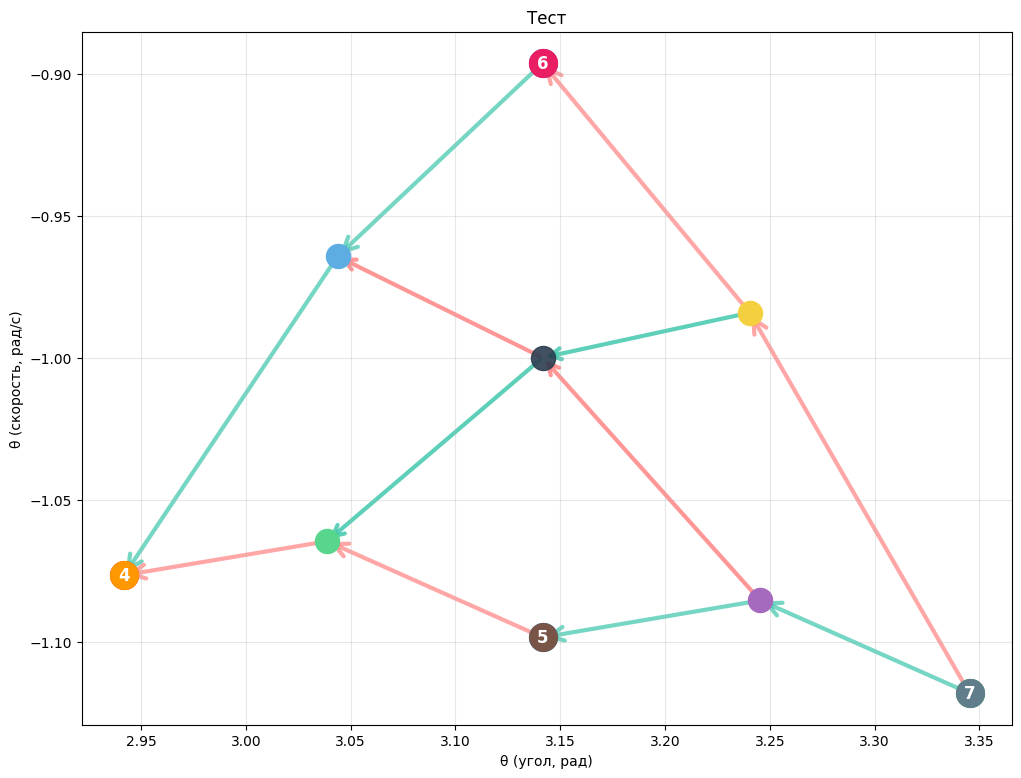

In [64]:
dt_children = np.abs(optimization_results['dt_children'])
dt_grandchildren = np.abs(optimization_results['dt_grandchildren'])

optimized_tree = SporeTree(pendulum, cfg, 
                          dt_children=dt_children, 
                          dt_grandchildren=dt_grandchildren)

visualize_spore_tree(optimized_tree, "Тест")